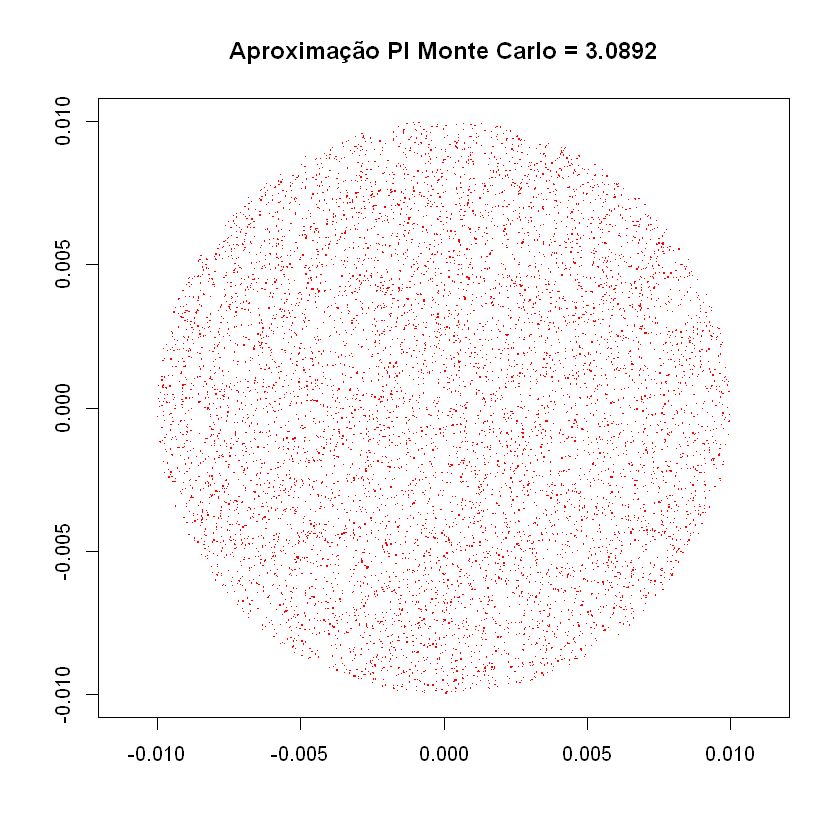

In [1]:
n_sim <- 10000
minimo <- -0.01
if(minimo >= 0){
    break
}
maximo <- -minimo
x <- runif(n_sim, minimo, maximo)
y <- runif(n_sim, minimo, maximo)

dentro_circulo <- x^2 + y^2 <= maximo^2

pi_monte_carlo <- (sum(dentro_circulo)/n_sim)*4

plot(x,y,pch='.',col=ifelse(dentro_circulo,"red","white")
    ,xlab='', ylab='',asp=1,
    main=paste("Aproximação PI Monte Carlo =", pi_monte_carlo))

In [1]:
u <- 0.2654333

sd <- 0.2127047

periodo <- 1:256

In [2]:
n_sim <- 2000
total_sim <- matrix(0, nrow = 256, ncol = n_sim)
p_inicial <- 100

In [3]:
for(j in 1:n_sim){
    aux <- 2
    p <- p_inicial
    preco <- c(p)
    dist <- rnorm(255, 0, 1)
    for(i in dist)
    {
        P = p + p*(u/255 + sd/sqrt(255)*i)
        preco[aux] <- P
        p = P
        aux = aux + 1
    }
    total_sim[,j] <- preco
}

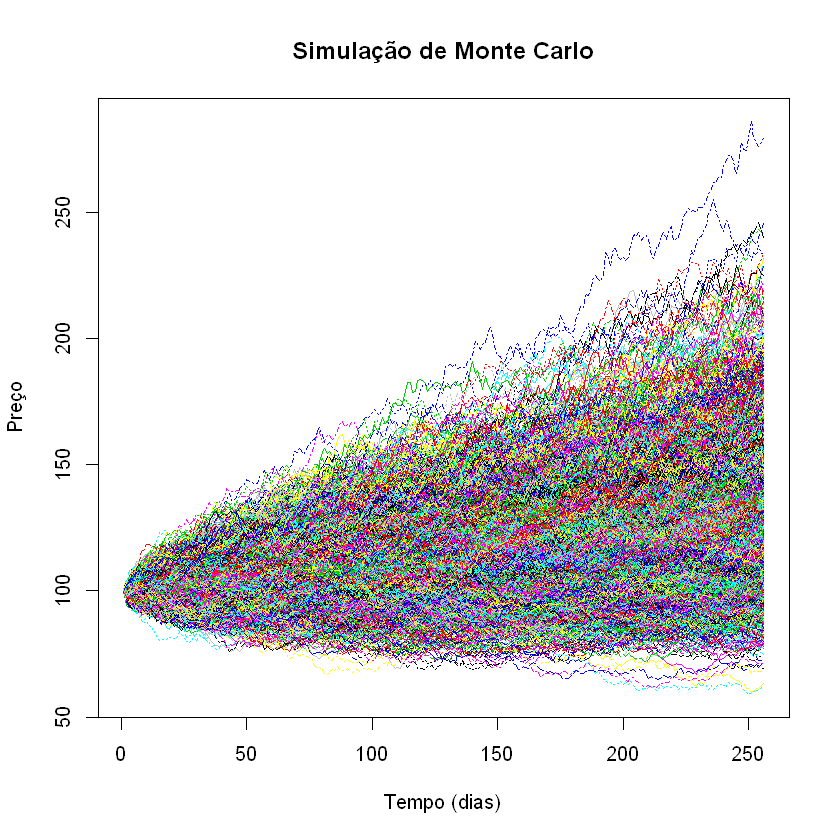

In [4]:
matplot(total_sim,main="Simulação de Monte Carlo",xlab="Tempo (dias)",ylab="Preço",col=1:n_sim, type = "l")

In [5]:
round(quantile(total_sim,probs=c(0.05,0.95)),2)

5%    95% 
 89.67 154.48

In [6]:
Ug <- (1+u)^(1/255)-1
VaR5 <- round((1-exp(-1.65*sd/sqrt(255)+Ug))*100,3)
names(VaR5) <- "VaR em % com 5% chance"
VaR5
VaR1 <- round((1-exp(-2.33*sd/sqrt(255)+Ug))*100,3)
names(VaR1) <- "VaR em % com 1% de chance"
VaR1

VaR em % com 5% chance 
                 2.083

VaR em % com 1% de chance 
                    2.966

In [7]:
round(min(total_sim),2)

[1] 58.86

In [8]:
estatisticas <- round(c(mean(total_sim[256,]), min(total_sim),
                  max(total_sim), 100*(quantile(total_sim[256,], probs = 0.5)/p_inicial)-100),2)
names(estatisticas) <- c("Média final", "Mínimo", "Máximo", "Retorno 50%")
print(estatisticas)

Média final      Mínimo      Máximo Retorno 50% 
     131.42       58.86      286.25       27.84 


In [9]:
fora_curva <- round(c(((min(total_sim)/p_inicial)-1)*100,
                      ((max(total_sim)/p_inicial)-1)*100),3)
names(fora_curva) <- c("Perda Máxima %", "Ganho Máximo %")
fora_curva

Perda Máxima % Ganho Máximo % 
       -41.135        186.247